# Imports and set the random seed to 42 for reproducibility

In [1]:
import os
import random
import numpy as np
import pandas as pd


# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Image processing imports
import cv2
from glob import glob

# Machine learning & deep learning imports
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D,
                                    MaxPooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (ModelCheckpoint, ReduceLROnPlateau,
                                      EarlyStopping)

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


2025-05-27 13:00:33.063016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 13:00:33.260335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 13:00:33.320389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 13:00:33.595606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 13:00:36.671989: W tensorflow/compiler/tf2

# shared visualisation functions and evaluation function for evaluation of my models

In [ ]:
def plot_training_history(history, title="Model Training History"):
    """Plot training history with accuracy and loss"""
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(model, X_test, y_test, labels, model_name="Model"):
    """Comprehensive model evaluation"""
    print(f"\n{'='*50}")
    print(f"{model_name.upper()} EVALUATION")
    print(f"{'='*50}")
    
    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
    
    # Confusion matrix
    plot_confusion_matrix(y_true_classes, y_pred_classes, labels, 
                         f'{model_name} - Confusion Matrix')
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=labels))
    
    return y_pred, y_pred_classes, y_true_classes

# read in data files

In [ ]:
UTKFACE_PATH = "datasets/UTKFace"  
FER2013_PATH = "datasets/fer2013/fer2013.csv" 

# Check if datasets exist
print("UTKFace dataset exists:", os.path.exists(UTKFACE_PATH))
print("FER2013 dataset exists:", os.path.exists(FER2013_PATH))

UTKFace dataset exists: True
FER2013 dataset exists: True


# Model 1: Gender detection model

In [ ]:
class GenderClassifier:
    def __init__(self, dataset_path=None, img_size=200):
        self.DATASET_PATH = dataset_path
        self.IMG_HEIGHT, self.IMG_WIDTH = img_size, img_size
        self.BATCH_SIZE = 32
        self.EPOCHS = 20
        self.NUM_CLASSES = 2
        self.gender_labels = ['Male', 'Female']
        
    def get_utkface_metadata(self):
        """Create a metadata DataFrame with paths and labels"""
        image_paths = glob(os.path.join(self.DATASET_PATH, "*.jpg"))
        valid_paths, genders = [], []
        error_count = 0
        
        for path in image_paths:
            try:
                filename = os.path.basename(path)
                age_gender_race = filename.split("_")
                
                if len(age_gender_race) < 3:
                    error_count += 1
                    continue
                    
                gender = int(age_gender_race[1])
                if gender not in [0, 1]:
                    error_count += 1
                    continue
                
                valid_paths.append(path)
                genders.append(gender)
                
            except Exception:
                error_count += 1
                continue
        
        metadata_df = pd.DataFrame({'path': valid_paths, 'gender': genders})
        
        print(f"Found {len(metadata_df)} valid images.")
        print(f"Skipped {error_count} images due to errors.")
        male_count = np.sum(metadata_df['gender'] == 0)
        female_count = np.sum(metadata_df['gender'] == 1)
        print(f"Gender distribution: Male: {male_count}, Female: {female_count}")
        
        return metadata_df
    
    def preprocess_image_grayscale(self, path):
        """Load and preprocess a single image into grayscale"""
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return np.zeros((self.IMG_HEIGHT, self.IMG_WIDTH, 1))
        
        img = cv2.resize(img, (self.IMG_WIDTH, self.IMG_HEIGHT))
        img = img / 255.0
        return img.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)
    
    def create_dataset(self, metadata_df, max_samples_per_class=2000):
        """Create a balanced dataset"""
        male_indices = metadata_df[metadata_df['gender'] == 0].index.tolist()
        female_indices = metadata_df[metadata_df['gender'] == 1].index.tolist()
        
        if max_samples_per_class:
            male_indices = np.random.choice(male_indices, 
                                          min(max_samples_per_class, len(male_indices)), 
                                          replace=False)
            female_indices = np.random.choice(female_indices, 
                                            min(max_samples_per_class, len(female_indices)), 
                                            replace=False)
        
        balanced_indices = np.concatenate([male_indices, female_indices])
        np.random.shuffle(balanced_indices)
        balanced_df = metadata_df.loc[balanced_indices].reset_index(drop=True)
        
        print(f"Created balanced dataset with {len(balanced_df)} samples")
        
        X, y = [], []
        for i, row in balanced_df.iterrows():
            if i % 500 == 0:
                print(f"Processing image {i}/{len(balanced_df)}")
            
            img = self.preprocess_image_grayscale(row['path'])
            X.append(img)
            y.append(row['gender'])
        
        return np.array(X), np.array(y)
    
    def build_model(self):
        """Build CNN model for gender classification"""
        model = Sequential([
            Conv2D(16, (3, 3), activation='relu', 
                   input_shape=(self.IMG_HEIGHT, self.IMG_WIDTH, 1)),
            MaxPooling2D((2, 2)),
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(self.NUM_CLASSES, activation='softmax')
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
        return model
    
    def train_and_evaluate(self):
        """Complete training and evaluation pipeline"""
        print("="*60)
        print("GENDER CLASSIFICATION MODEL")
        print("="*60)
        
        # Data preparation
        metadata_df = self.get_utkface_metadata()
        X, y = self.create_dataset(metadata_df)
        
        # Visualize samples
        self.visualize_samples(X, y)
        
        # Split data
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
        
        print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")
        
        # Build and train model
        model = self.build_model()
        model.summary()
        
        # Callbacks
        callbacks = [
            ModelCheckpoint('gender_model_best.keras', monitor='val_accuracy', 
                          save_best_only=True, mode='max', verbose=1),
            EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                         restore_best_weights=True)
        ]
        
        # Class weights
        class_weights = class_weight.compute_class_weight(
            'balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
        # Train
        history = model.fit(X_train, y_train, batch_size=self.BATCH_SIZE,
                           epochs=self.EPOCHS, validation_data=(X_val, y_val),
                           callbacks=callbacks, class_weight=class_weight_dict,
                           verbose=1)
        
        # Plot training history
        plot_training_history(history, "Gender Classification")
        
        # Evaluate

        evaluate_model_performance(model, X_test, y_test, 
                                 self.gender_labels, "Gender Classification")
        
        model.save('gender_model_final.keras')
        return model, history
    
    def visualize_samples(self, X, y, n_samples=10):
        """Visualize sample images"""
        plt.figure(figsize=(20, 4))
        indices = np.random.choice(range(len(X)), min(n_samples, len(X)), replace=False)
        
        for i, idx in enumerate(indices):
            plt.subplot(1, min(n_samples, len(X)), i+1)
            plt.imshow(X[idx].reshape(self.IMG_HEIGHT, self.IMG_WIDTH), cmap='gray')
            plt.title(self.gender_labels[y[idx]])
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

GENDER CLASSIFICATION MODEL
Found 23708 valid images.
Skipped 0 images due to errors.
Gender distribution: Male: 12391, Female: 11317
Created balanced dataset with 4000 samples
Processing image 0/4000
Processing image 500/4000
Processing image 1000/4000
Processing image 1500/4000
Processing image 2000/4000
Processing image 2500/4000
Processing image 3000/4000
Processing image 3500/4000


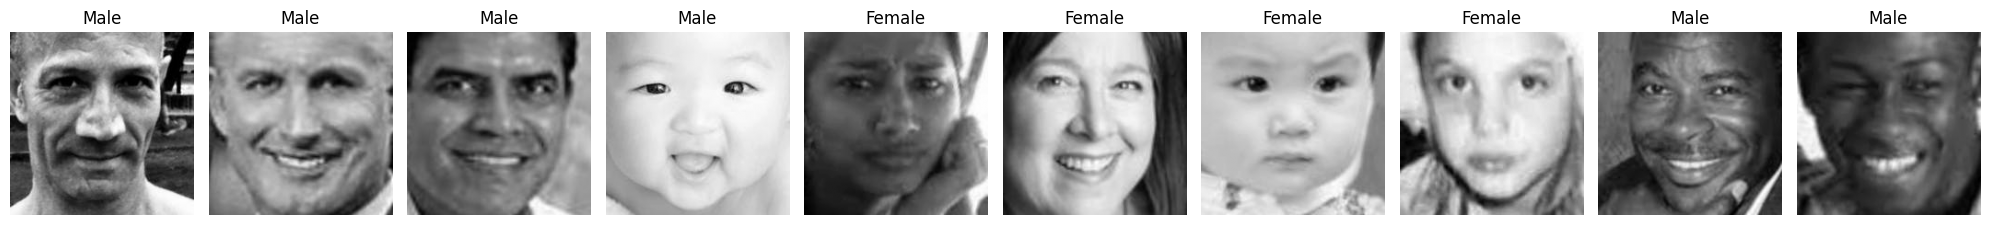

Train: 2800, Val: 600, Test: 600


/home/thomas/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748325647.077844   30995 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:23:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748325647.363310   30995 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:23:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748325647.363437   30995 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:23:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748325647.369354   30995 cu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,166,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,274 (8.36 MB)

 Trainable params: 2,190,274 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

2025-05-27 13:00:51.314617: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 448000000 exceeds 10% of free system memory.
2025-05-27 13:00:51.746229: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 448000000 exceeds 10% of free system memory.


Epoch 1/20


I0000 00:00:1748325653.818292   31096 service.cc:146] XLA service 0x7fcad4006be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748325653.818388   31096 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-05-27 13:00:53.899968: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-27 13:00:54.187927: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


10/88 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5527 - loss: 1.1088

I0000 00:00:1748325658.774805   31096 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5900 - loss: 0.7701
Epoch 1: val_accuracy improved from -inf to 0.78000, saving model to gender_model_best.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.5908 - loss: 0.7687 - val_accuracy: 0.7800 - val_loss: 0.4997
Epoch 2/20
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7845 - loss: 0.4720
Epoch 2: val_accuracy improved from 0.78000 to 0.81833, saving model to gender_model_best.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7849 - loss: 0.4714 - val_accuracy: 0.8183 - val_loss: 0.3871
Epoch 3/20
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8237 - loss: 0.3744
Epoch 3: val_accuracy improved from 0.81833 to 0.83667, saving model to gender_model_best.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8241 - loss: 0.3741 - val_accuracy: 0.8367 - val_loss: 0.3494
Epoch 4/20
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8640 - loss: 0.3129
Epoch 4: val_accuracy did not improve

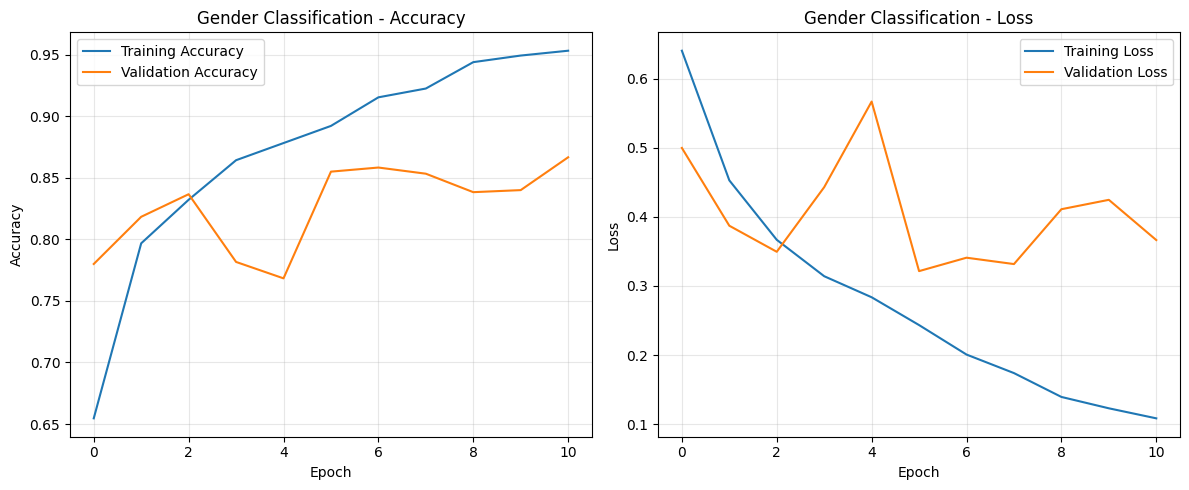


GENDER CLASSIFICATION EVALUATION
Test Loss: 0.3996
Test Accuracy: 0.8417


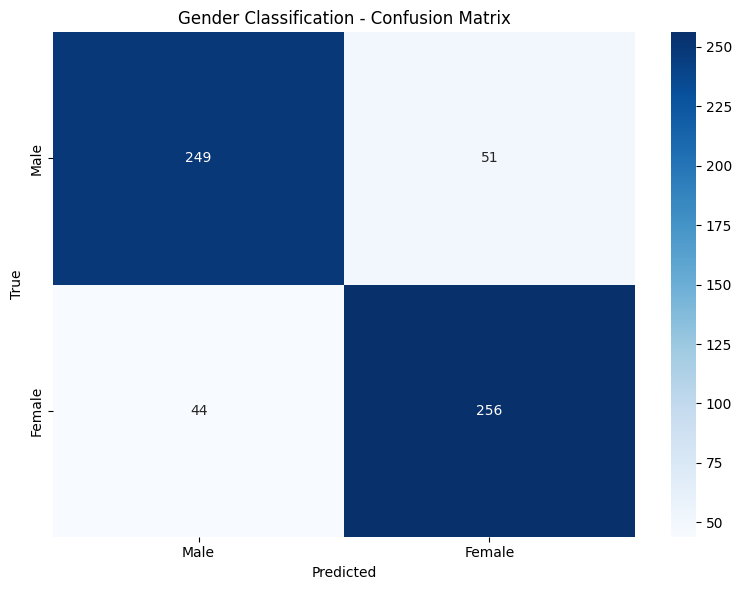


Gender Classification Classification Report:
              precision    recall  f1-score   support

        Male       0.85      0.83      0.84       300
      Female       0.83      0.85      0.84       300

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



In [5]:
gender_classifier = GenderClassifier(dataset_path=UTKFACE_PATH, img_size=200)
gender_model, gender_history = gender_classifier.train_and_evaluate()

# Model 2: age classification

In [ ]:
class AgeClassifier:
    def __init__(self, dataset_path="datasets/UTKFace", img_size=200):
        self.DATASET_PATH = dataset_path
        self.IMG_HEIGHT, self.IMG_WIDTH = img_size, img_size
        self.BATCH_SIZE = 16
        self.EPOCHS = 20
        self.age_groups = [(0, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 100)]
        self.age_labels = ["0-2", "3-9", "10-20", "21-27", "28-45", "46-65", "66+"]
        self.NUM_CLASSES = len(self.age_groups)
    
    def get_age_label(self, age):
        """Map age to age group"""
        for i, (low, high) in enumerate(self.age_groups):
            if low <= age <= high:
                return i
        return None
    
    def get_utkface_metadata(self):
        """Create a metadata DataFrame with paths and labels"""
        image_paths = glob(os.path.join(self.DATASET_PATH, "*.jpg"))
        valid_paths, ages = [], []
        error_count = 0
        
        # Limit total images processed to prevent memory overflow
        max_images_to_process = 12000
        
        for i, path in enumerate(image_paths[:max_images_to_process]):
            try:
                filename = os.path.basename(path)
                age_gender_race = filename.split("_")
                
                if len(age_gender_race) < 3:
                    error_count += 1
                    continue
                    
                age = int(age_gender_race[0])
                age_label = self.get_age_label(age)
                
                if age_label is None:
                    error_count += 1
                    continue
                
                valid_paths.append(path)
                ages.append(age_label)
                
            except Exception:
                error_count += 1
                continue
        
        metadata_df = pd.DataFrame({'path': valid_paths, 'age_group': ages})
        
        print(f"Found {len(metadata_df)} valid images from {len(image_paths)} total.")
        print(f"Skipped {error_count} images due to errors.")
        
        # Print age group distribution
        for i, label in enumerate(self.age_labels):
            count = np.sum(metadata_df['age_group'] == i)
            print(f"Age group {label}: {count}")
        
        return metadata_df
    
    def preprocess_image_grayscale(self, path):
        """Load and preprocess a single image into grayscale"""
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return np.zeros((self.IMG_HEIGHT, self.IMG_WIDTH, 1))
        
        img = cv2.resize(img, (self.IMG_WIDTH, self.IMG_HEIGHT))
        img = img / 255.0
        return img.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)
    
    def create_dataset(self, metadata_df, max_samples_per_class=1200): 
        """Create a balanced dataset"""
        
        # Get indices for each age group
        age_group_indices = {}
        for i in range(self.NUM_CLASSES):
            indices = metadata_df[metadata_df['age_group'] == i].index.tolist()
            # Limit samples per class
            if len(indices) > max_samples_per_class:
                indices = np.random.choice(indices, max_samples_per_class, replace=False)
            age_group_indices[i] = indices
        
        # Collect balanced indices
        balanced_indices = []
        for i in range(self.NUM_CLASSES):
            balanced_indices.extend(age_group_indices[i])
        
        np.random.shuffle(balanced_indices)
        balanced_df = metadata_df.loc[balanced_indices].reset_index(drop=True)
        
        print(f"Created balanced dataset with {len(balanced_df)} samples")
        print(f"Max samples per class: {max_samples_per_class}")
        
        # Process images in smaller batches
        X, y = [], []
        batch_size = 300
        
        for i in range(0, len(balanced_df), batch_size):
            batch_end = min(i + batch_size, len(balanced_df))
            batch_df = balanced_df.iloc[i:batch_end]
            
            print(f"Processing batch {i//batch_size + 1}/{(len(balanced_df)-1)//batch_size + 1} "
                  f"(images {i}-{batch_end-1})")
            
            batch_X, batch_y = [], []
            for _, row in batch_df.iterrows():
                img = self.preprocess_image_grayscale(row['path'])
                batch_X.append(img)
                batch_y.append(row['age_group'])
            
            X.extend(batch_X)
            y.extend(batch_y)
            
            # Clear batch data to free memory
            del batch_X, batch_y
            
            # Force garbage collection every few batches
            if (i // batch_size) % 5 == 0:
                import gc
                gc.collect()
        
        return np.array(X), np.array(y)
    
    def build_model(self):
        """Build LIGHTWEIGHT CNN model for age classification"""
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(self.IMG_HEIGHT, self.IMG_WIDTH, 1)),
            MaxPooling2D(2, 2),

            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),

            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),

            Conv2D(256, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),

            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(self.NUM_CLASSES, activation='softmax')
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
        return model
    
    def train_and_evaluate(self):
        """Complete training and evaluation pipeline"""
        print("="*60)
        print("AGE CLASSIFICATION MODEL")
        print("="*60)
        
        # Force garbage collection at start
        import gc
        gc.collect()
        
        # Data preparation
        print("Loading metadata...")
        metadata_df = self.get_utkface_metadata()
        
        print("Creating dataset...")
        X, y = self.create_dataset(metadata_df, max_samples_per_class=1200)
        
        # Visualize samples
        self.visualize_samples(X, y, n_samples=7)
        
        # Split data
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
        
        print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")
        
        # Clear original arrays to free memory
        del X, y, X_temp, y_temp
        gc.collect()
        
        # Build and train model
        model = self.build_model()
        model.summary()
        
        # Callbacks
        callbacks = [
            ModelCheckpoint('age_model_best.keras', monitor='val_accuracy', 
                          save_best_only=True, mode='max', verbose=1),
            EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                         restore_best_weights=True),
            # Add memory cleanup callback
            tf.keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, logs: gc.collect()
            )
        ]
        
        # Class weights for handling imbalanced age groups
        try:
            class_weights = class_weight.compute_class_weight(
                'balanced', classes=np.unique(y_train), y=y_train)
            class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        except:
            print("Warning: Could not compute class weights, using equal weights")
            class_weight_dict = None
        
        # Train model
        history = model.fit(X_train, y_train, batch_size=self.BATCH_SIZE,
                               epochs=self.EPOCHS, validation_data=(X_val, y_val),
                               callbacks=callbacks, class_weight=class_weight_dict,
                               verbose=1)
        
        # Plot training history
        plot_training_history(history, "Age Classification")
        
        # Evaluate - use sparse labels (integers) not categorical
        evaluate_model_performance(model, X_test, y_test, 
                                 self.age_labels, "Age Classification")
        
        model.save('age_model_final.keras')
        return model, history
    
    def visualize_samples(self, X, y, n_samples=7):
        """Visualize sample images"""
        plt.figure(figsize=(14, 3))
        indices = np.random.choice(range(len(X)), min(n_samples, len(X)), replace=False)
        
        for i, idx in enumerate(indices):
            plt.subplot(1, min(n_samples, len(X)), i+1)
            plt.imshow(X[idx].reshape(self.IMG_HEIGHT, self.IMG_WIDTH), cmap='gray')
            plt.title(self.age_labels[y[idx]])
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

AGE CLASSIFICATION MODEL (Memory Optimized)
Loading metadata...
Found 11988 valid images from 23708 total.
Skipped 12 images due to errors.
Age group 0-2: 825
Age group 3-9: 736
Age group 10-20: 920
Age group 21-27: 2797
Age group 28-45: 3844
Age group 46-65: 2020
Age group 66+: 846
Creating dataset...
Created balanced dataset with 6927 samples
Max samples per class: 1200
Processing batch 1/24 (images 0-299)
Processing batch 2/24 (images 300-599)
Processing batch 3/24 (images 600-899)
Processing batch 4/24 (images 900-1199)
Processing batch 5/24 (images 1200-1499)
Processing batch 6/24 (images 1500-1799)
Processing batch 7/24 (images 1800-2099)
Processing batch 8/24 (images 2100-2399)
Processing batch 9/24 (images 2400-2699)
Processing batch 10/24 (images 2700-2999)
Processing batch 11/24 (images 3000-3299)
Processing batch 12/24 (images 3300-3599)
Processing batch 13/24 (images 3600-3899)
Processing batch 14/24 (images 3900-4199)
Processing batch 15/24 (images 4200-4499)
Processing ba

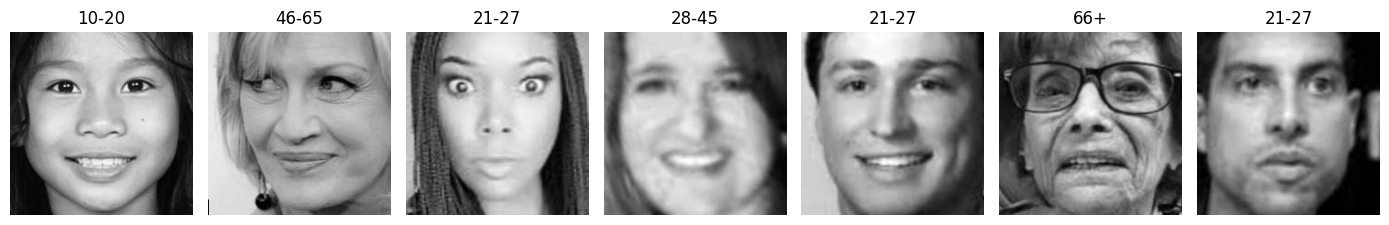

Train: 4848, Val: 1039, Test: 1040


/home/thomas/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,553,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,943,495 (26.49 MB)

 Trainable params: 6,943,495 (26.49 MB)

 Non-trainable params: 0 (0.00 B)

2025-05-27 13:02:11.872063: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 775680000 exceeds 10% of free system memory.
2025-05-27 13:02:13.436521: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 775680000 exceeds 10% of free system memory.


Epoch 1/20
302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1828 - loss: 1.9112
Epoch 1: val_accuracy improved from -inf to 0.39076, saving model to age_model_best.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.1831 - loss: 1.9104 - val_accuracy: 0.3908 - val_loss: 1.5232
Epoch 2/20
301/303 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3873 - loss: 1.4550
Epoch 2: val_accuracy improved from 0.39076 to 0.44851, saving model to age_model_best.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.3876 - loss: 1.4543 - val_accuracy: 0.4485 - val_loss: 1.3063
Epoch 3/20
301/303 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4561 - loss: 1.2678
Epoch 3: val_accuracy improved from 0.44851 to 0.49567, saving model to age_model_best.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4563 - loss: 1.2672 - val_accuracy: 0.4957 - val_loss: 1.1924
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5139 - loss: 1.1338
Epoch 4: val_accuracy

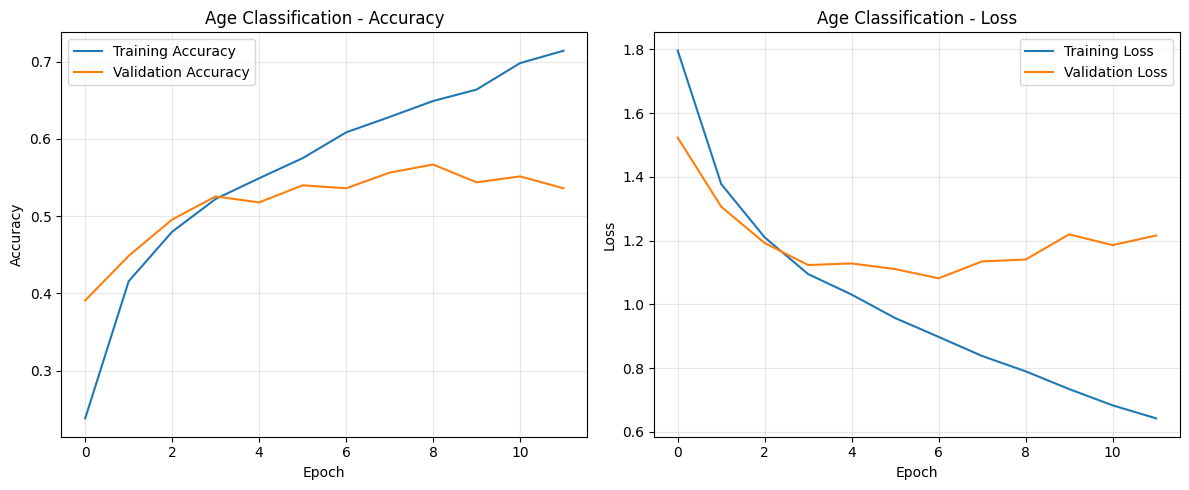


AGE CLASSIFICATION EVALUATION
Test Loss: 1.0688
Test Accuracy: 0.5519


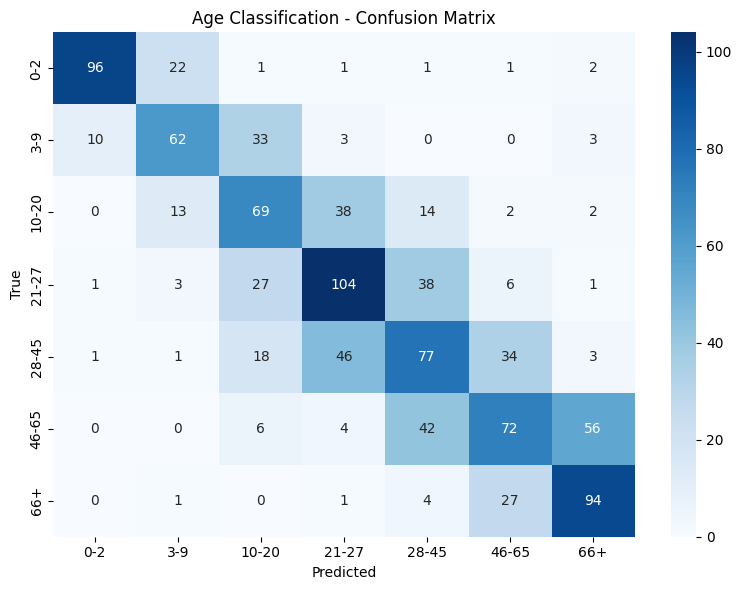


Age Classification Classification Report:
              precision    recall  f1-score   support

         0-2       0.89      0.77      0.83       124
         3-9       0.61      0.56      0.58       111
       10-20       0.45      0.50      0.47       138
       21-27       0.53      0.58      0.55       180
       28-45       0.44      0.43      0.43       180
       46-65       0.51      0.40      0.45       180
         66+       0.58      0.74      0.65       127

    accuracy                           0.55      1040
   macro avg       0.57      0.57      0.57      1040
weighted avg       0.56      0.55      0.55      1040



In [7]:
age_classifier = AgeClassifier(dataset_path=UTKFACE_PATH, img_size=200)
age_model, age_history = age_classifier.train_and_evaluate()

# Model 3: Emotion detection

In [ ]:
class EmotionClassifier:
    def __init__(self, dataset_path="datasets/fer2013/fer2013.csv"):
        self.DATASET_PATH = dataset_path
        self.IMG_HEIGHT, self.IMG_WIDTH = 48, 48
        self.BATCH_SIZE = 32
        self.EPOCHS = 30
        self.NUM_CLASSES = 2
        self.HAPPY_INDEX = 3
        self.SAD_INDEX = 4
        self.emotion_labels = ['Happy', 'Sad']
    
    def load_fer2013_data(self):
        """Load and preprocess data"""
        data = pd.read_csv(self.DATASET_PATH)
        
        # Filter only Happy and Sad emotions
        data = data[(data['emotion'] == self.HAPPY_INDEX) | 
                   (data['emotion'] == self.SAD_INDEX)]
        
        # Map to binary labels
        data['binary_emotion'] = data['emotion'].map({self.HAPPY_INDEX: 0, self.SAD_INDEX: 1})
        
        # Convert pixels to arrays
        pixels = data['pixels'].apply(lambda x: np.array(x.split(' ')).astype('float32'))
        pixels = pixels.apply(lambda x: x / 255.0)
        
        # Reshape data
        X = np.stack(pixels.values)
        X = X.reshape(X.shape[0], self.IMG_HEIGHT, self.IMG_WIDTH, 1)
        y = data['binary_emotion'].values
        
        return X, y
    
    def build_model(self):
        """Build CNN model for emotion classification"""
        model = Sequential([
            Conv2D(32, (3, 3), padding='same', activation='relu',
                   input_shape=(self.IMG_HEIGHT, self.IMG_WIDTH, 1)),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.2),
            
            Conv2D(64, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            Conv2D(64, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.3),
            
            Conv2D(128, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.4),
            
            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(self.NUM_CLASSES, activation='softmax')
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        return model
    
    def train_and_evaluate(self):
        print("="*60)
        print("EMOTION CLASSIFICATION MODEL")
        print("="*60)
        
        # Load data
        X, y = self.load_fer2013_data()
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.1, random_state=42)
        
        # Calculate class weights
        class_weights = class_weight.compute_class_weight(
            'balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
        # Convert to categorical
        y_train = to_categorical(y_train, self.NUM_CLASSES)
        y_val = to_categorical(y_val, self.NUM_CLASSES)
        y_test = to_categorical(y_test, self.NUM_CLASSES)
        
        print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")
        print(f"Class weights: {class_weight_dict}")
        
        # Build model
        model = self.build_model()
        model.summary()
        
        # Callbacks
        callbacks = [
            ModelCheckpoint('emotion_model_best.keras', monitor='val_accuracy',
                          save_best_only=True, mode='max', verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,
                            min_lr=1e-6, verbose=1),
            EarlyStopping(monitor='val_loss', patience=8, verbose=1,
                         restore_best_weights=True)
        ]
        
        # Train
        history = model.fit(X_train, y_train, batch_size=self.BATCH_SIZE,
                           epochs=50, validation_data=(X_val, y_val),
                           callbacks=callbacks, class_weight=class_weight_dict,
                           verbose=1)
        
        # Plot training history
        plot_training_history(history, "Emotion Classification")
        
        # Evaluate
        evaluate_model_performance(model, X_test, y_test,
                                 self.emotion_labels, "Emotion Classification")
        
        model.save('emotion_model_final.keras')
        return model, history

EMOTION CLASSIFICATION MODEL
Train: 12203, Val: 1356, Test: 1507
Class weights: {0: 0.8363947909527073, 1: 1.2431744091279544}


/home/thomas/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,312,194 (5.01 MB)

 Trainable params: 1,311,106 (5.00 MB)

 Non-trainable params: 1,088 (4.25 KB)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5448 - loss: 1.1484
Epoch 1: val_accuracy improved from -inf to 0.40265, saving model to emotion_model_best.keras
382/382 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.5449 - loss: 1.1482 - val_accuracy: 0.4027 - val_loss: 1.7458 - learning_rate: 1.0000e-04
Epoch 2/50
378/382 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6351 - loss: 0.8865
Epoch 2: val_accuracy improved from 0.40265 to 0.67330, saving model to emotion_model_best.keras
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6351 - loss: 0.8860 - val_accuracy: 0.6733 - val_loss: 0.6535 - learning_rate: 1.0000e-04
Epoch 3/50
380/382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6629 - loss: 0.7728
Epoch 3: val_accuracy improved from 0.67330 to 0.73009, saving model to emotion_model_best.keras
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6630 - loss: 0.7726 - val_accuracy: 0.7301 - val_loss: 0.5235 - learning_rate: 1.0000e-04
Epoch 4/50
38

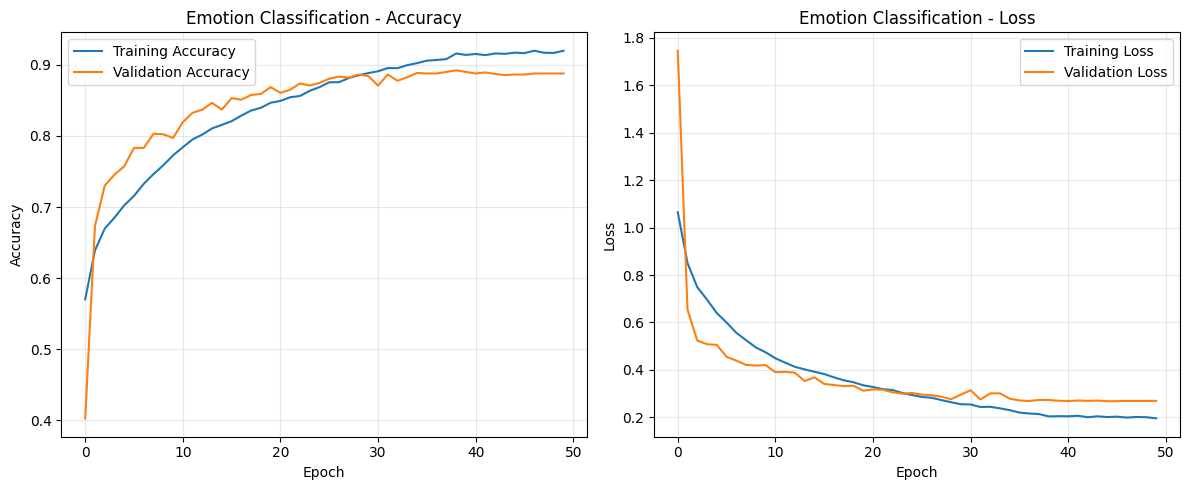


EMOTION CLASSIFICATION EVALUATION
Test Loss: 0.2615
Test Accuracy: 0.8998


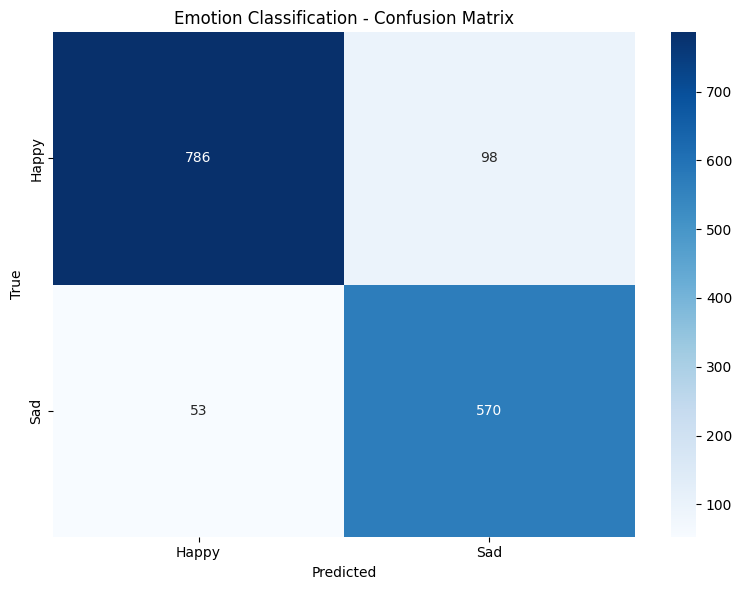


Emotion Classification Classification Report:
              precision    recall  f1-score   support

       Happy       0.94      0.89      0.91       884
         Sad       0.85      0.91      0.88       623

    accuracy                           0.90      1507
   macro avg       0.90      0.90      0.90      1507
weighted avg       0.90      0.90      0.90      1507



In [9]:
emotion_classifier = EmotionClassifier(dataset_path=FER2013_PATH)
emotion_model, emotion_history = emotion_classifier.train_and_evaluate()

# Compare all models at once together

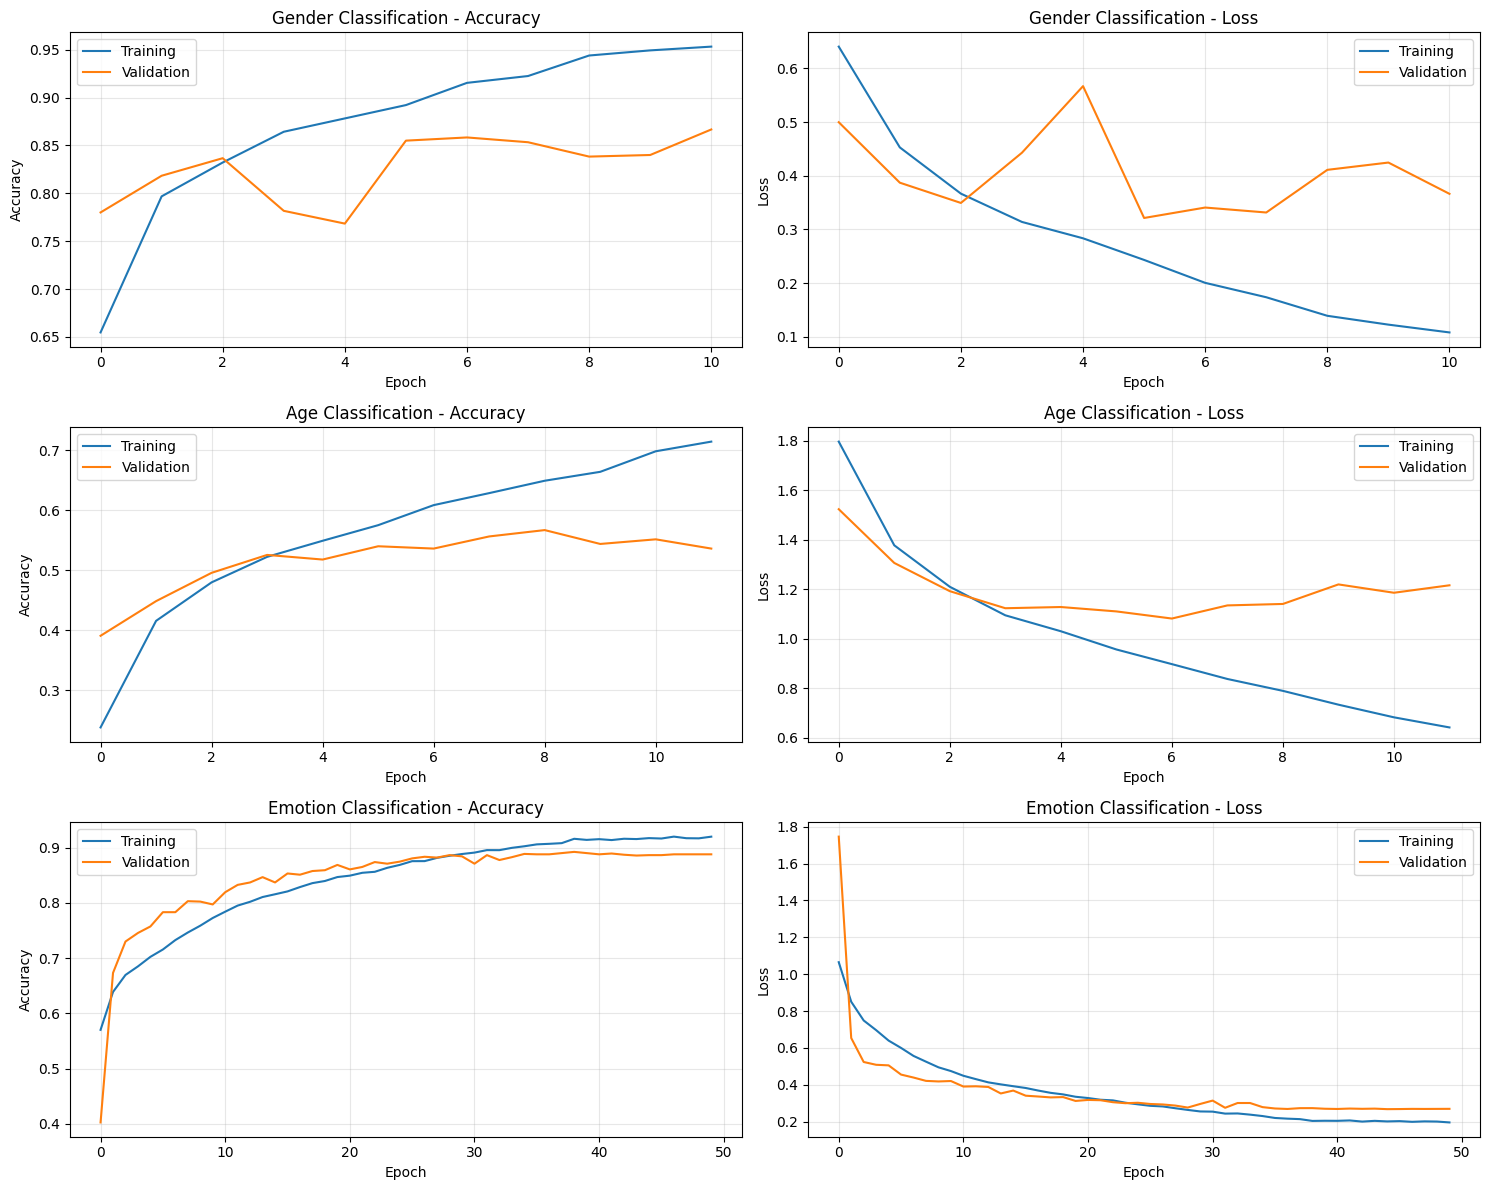


Final Model Accuracies:
----------------------------------------
Gender Classification: 0.8667
Age Classification: 0.5669
Emotion Classification: 0.8923


In [10]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

models_data = [
    (gender_history, "Gender Classification"),
    (age_history, "Age Classification"), 
    (emotion_history, "Emotion Classification")
]

for i, (history, title) in enumerate(models_data):
    # Accuracy plot
    axes[i, 0].plot(history.history['accuracy'], label='Training')
    axes[i, 0].plot(history.history['val_accuracy'], label='Validation')
    axes[i, 0].set_title(f'{title} - Accuracy')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].set_ylabel('Accuracy')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[i, 1].plot(history.history['loss'], label='Training')
    axes[i, 1].plot(history.history['val_loss'], label='Validation')
    axes[i, 1].set_title(f'{title} - Loss')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].set_ylabel('Loss')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final accuracies
print("\nFinal Model Accuracies:")
print("-" * 40)
for history, title in models_data:
    final_val_acc = max(history.history['val_accuracy'])
    print(f"{title}: {final_val_acc:.4f}")

# Convertion from keras to tflite

In [ ]:
import tensorflow as tf

# load trained models
model_age = tf.keras.models.load_model('age_model_final.keras')
model_gender = tf.keras.models.load_model('gender_model_final.keras')
model_emotion = tf.keras.models.load_model('emotion_model_final.keras')

# Convert the model to TFLite format
converter_age = tf.lite.TFLiteConverter.from_keras_model(model_age)
tflite_model_age = converter_age.convert()

# Save the TFLite model to a file
with open('model_age.tflite', 'wb') as f:
    f.write(tflite_model_age)

converter_gender = tf.lite.TFLiteConverter.from_keras_model(model_gender)
tflite_model_gender = converter_gender.convert()

# Save the TFLite model to a file
with open('model_gender.tflite', 'wb') as f:
    f.write(tflite_model_gender)

converter_emotion = tf.lite.TFLiteConverter.from_keras_model(model_emotion)
tflite_model_emotion = converter_emotion.convert()

# Save the TFLite model to a file
with open('model_emotion.tflite', 'wb') as f:
    f.write(tflite_model_emotion)